In [1]:
# Do this only in Colab notebooks! Otherwise use pip install unsloth
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo -q
!pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer -q
!pip install --no-deps unsloth -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.8/544.8 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.5/561.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
unsloth-zoo 2025.8.9 requires msgspec, which is not installed.
unsloth-zoo 2025.8.9 requires tyro, which is not installed.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cu

In [2]:
# ===================================================================
# Block 1: Imports and Global Configuration
# ===================================================================
import json
import os
import re
from typing import List, Dict
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import torch
import gc

# Assuming unsloth is installed and available
from unsloth import FastVisionModel

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-08-31 07:09:49.083097: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756624189.425478      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756624189.532342      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!


In [3]:
# ===================================================================
# Block 2: Core Data Loading & Path Utilities (MODIFIED FOR TRAINING DATA)
# ===================================================================

def resize_image_if_needed(image_path: str, threshold: int = 768) -> Image.Image:
    """Loads and resizes an image proportionally if it exceeds the threshold."""
    img = Image.open(image_path).convert("RGB")
    width, height = img.size
    if width > threshold or height > threshold:
        ratio = threshold / max(width, height)
        new_size = (int(width * ratio), int(height * ratio))
        return img.resize(new_size, Image.Resampling.LANCZOS)
    return img

def load_train_data() -> tuple:
    """Loads the train questions and law database."""
    train_json_path = "/kaggle/input/vlsp-dataset/VLSP 2025 - MLQA-TSR Data Release-20250820T023346Z-1-001/VLSP 2025 - MLQA-TSR Data Release/train_data/vlsp_2025_train.json"
    law_db_path = "/kaggle/input/vlsp-dataset/VLSP 2025 - MLQA-TSR Data Release-20250820T023346Z-1-001/VLSP 2025 - MLQA-TSR Data Release/law_db/vlsp2025_law_new.json"

    with open(train_json_path, 'r', encoding='utf-8') as f:
        train_questions = json.load(f)
    with open(law_db_path, 'r', encoding='utf-8') as f:
        law_database = json.load(f)

    # Filter for questions that have a ground truth answer
    answered_questions = [
        q for q in train_questions if q.get("answer")
    ]
    if not answered_questions:
        print("🚨 Warning: Loaded 0 questions with an 'answer' field. The input file might be empty or formatted incorrectly.")
    else:
        print(f"Loaded {len(answered_questions)} answered questions for processing.")
    return answered_questions, law_database

def get_relevant_articles(question_data: dict, law_database: list) -> list:
    """Extracts structured article data for a question."""
    relevant_articles = []
    for ref in question_data.get("relevant_articles", []):
        for law in law_database:
            if law["id"] == ref["law_id"]:
                for article in law["articles"]:
                    if article["id"] == ref["article_id"]:
                        relevant_articles.append({
                            "law_id": law["id"], "law_title": law["title"], "article_id": article["id"],
                            "article_title": article["title"], "article_text": article["text"]
                        })
                        break
                break
    return relevant_articles

def get_article_images(article_text: str) -> (List[str], List[Image.Image]):
    """Finds, loads, and returns all images mentioned in an article's text."""
    image_filenames = re.findall(r'<<IMAGE: (.*?) /IMAGE>>', article_text)
    base_path = "/kaggle/input/vlsp-dataset/VLSP 2025 - MLQA-TSR Data Release-20250820T023346Z-1-001/VLSP 2025 - MLQA-TSR Data Release/law_db/images/images.fld"
    loaded_images, valid_paths = [], []
    for fname in image_filenames:
        path = os.path.join(base_path, fname.strip())
        if os.path.exists(path):
            try:
                loaded_images.append(resize_image_if_needed(path))
                valid_paths.append(path)
            except Exception as e:
                print(f"Warning: Could not load article image {path}. Error: {e}")
    return valid_paths, loaded_images

def get_train_image_path(image_id: str) -> str:
    """Constructs the exact path for a main training image without fallbacks."""
    base_path = "/kaggle/input/vlsp-dataset/VLSP 2025 - MLQA-TSR Data Release-20250820T023346Z-1-001/VLSP 2025 - MLQA-TSR Data Release/train_data/train_images/train_images"
    # Only check for .jpg as it's the expected format. No silent fallback to .png.
    return os.path.join(base_path, f"{image_id}.jpg")

In [4]:
# ===================================================================
# Block 3: Image Merging and Visualization Utilities
# ===================================================================

def merge_images(images: List[Image.Image]) -> Image.Image:
    """Merges 2 or 3 images onto a single white canvas."""
    if not images: return None
    if len(images) == 1: return images[0]

    if len(images) >= 3: # Stack vertically
        max_w = max(img.width for img in images)
        total_h = sum(img.height for img in images)
        canvas = Image.new('RGB', (max_w, total_h), color='white')
        y_offset = 0
        for img in images:
            canvas.paste(img, ((max_w - img.width) // 2, y_offset))
            y_offset += img.height
        return canvas
    elif len(images) == 2: # Stack to be 'more square'
        w1, h1 = images[0].size
        w2, h2 = images[1].size
        if abs(((w1 + w2) / max(h1, h2)) - 1) < abs((max(w1, w2) / (h1 + h2)) - 1):
            canvas = Image.new('RGB', (w1 + w2, max(h1, h2)), color='white')
            canvas.paste(images[0], (0, 0)); canvas.paste(images[1], (w1, 0))
        else:
            canvas = Image.new('RGB', (max(w1, w2), h1 + h2), color='white')
            canvas.paste(images[0], (0, 0)); canvas.paste(images[1], (0, h1))
        return canvas
    return None

def display_sanity_check(main_image: Image.Image, article_images: List[Image.Image], prompt: str, output: str):
    """Renders images, prompt, and output for manual verification."""
    print("\n" + "="*25 + " SANITY CHECK " + "="*25)
    num_axes = 1 + len(article_images)
    fig, axes = plt.subplots(1, num_axes, figsize=(5 * num_axes, 5))
    axes = [axes] if num_axes == 1 else axes.flatten()

    axes[0].imshow(main_image); axes[0].set_title("Input Image (Scene)"); axes[0].axis('off')
    for i, article_image in enumerate(article_images):
        axes[i+1].imshow(article_image)
        axes[i+1].set_title(f"Article Image {i+1} (Merged)")
        axes[i+1].axis('off')

    plt.show()
    print("\n--- PROMPT SENT TO VLM ---\n" + prompt)
    print("\n--- VLM OUTPUT ---\n" + output)
    print("="*64 + "\n")

In [5]:
# ===================================================================
# Block 3.5: Markdown Output Parser
# ===================================================================

def parse_markdown_output(raw_output: str) -> Dict[str, str]:
    """
    Parses the VLM's raw output to extract content from Markdown headers.
    """
    sections = {
        "name": "Tên biển báo",
        "detail": "Chi tiết luật",
        "final": "Kết luận"
    }
    parsed_data = {}
    try:
        parsed_data["name"] = re.search(f"### {sections['name']}(.*?)\n### {sections['detail']}", raw_output, re.DOTALL| re.IGNORECASE).group(1).strip()
        parsed_data["detail"] = re.search(f"### {sections['detail']}(.*?)\n### {sections['final']}", raw_output, re.DOTALL| re.IGNORECASE).group(1).strip()
        final_split = re.split(f"### {sections['final']}", raw_output, maxsplit=1, flags=re.IGNORECASE)
        if len(final_split) > 1:
            parsed_data["final"] = final_split[1].strip()
        else:
            parsed_data["final"] = "Parsing Error: <Kết luận> section not found."
    except AttributeError:
        # This error is now more explicit
        print(f"🚨 Parsing Error: Could not find the expected markdown headers in the model output.\nRaw Output:\n---\n{raw_output}\n---")
        parsed_data = {
            "name": "Parsing Error", "detail": "Parsing Error", "final": "Parsing Error"
        }
    return parsed_data

In [6]:
# ===================================================================
# Block 4: Prompt Generation
# ===================================================================

def clean_article_text(text: str) -> str:
    """Cleans article text by removing image and table tags."""
    clean_text = re.sub(r'<<IMAGE: (.*?) /IMAGE>>', '', text)
    return re.sub(r'<<TABLE: (.*?) /TABLE>>', '', clean_text, flags=re.DOTALL).strip()

def make_rule_extraction_prompt(question: str, articles: List[Dict]) -> str:
    """Creates a tuned prompt for the Vision Rule Extraction task."""
    article_texts_formatted = ""
    for i, article in enumerate(articles, 1):
        clean_text = clean_article_text(article['article_text'])
        article_texts_formatted += f"**Điều luật tham khảo {i} ({article['law_id']} - {article['article_id']}):**\n{clean_text}\n\n"

    num_law_images = sum(1 for article in articles if '<<IMAGE:' in article['article_text'])
    
    if num_law_images > 0:
        law_image_refs = ", ".join([f"Hình {i+2}" for i in range(num_law_images)])
        info_source_description = f"""
1.  **Hình ảnh Tình huống (Hình 1):** Đây là hình ảnh chính chứa biển báo cần phân tích.
2.  **Hình ảnh Luật ({law_image_refs}):** Đây là các hình ảnh minh họa cho từng điều luật tương ứng.
3.  **Văn bản luật, Câu hỏi:** Cung cấp ngữ cảnh và mô tả chi tiết từ nhiều điều luật."""
    else:
        info_source_description = """
1.  **Hình ảnh Tình huống (Hình 1):** Đây là hình ảnh chính chứa biển báo cần phân tích.
2.  **Văn bản luật, Câu hỏi & Lựa chọn:** Cung cấp ngữ cảnh và mô tả chi tiết từ nhiều điều luật."""

    prompt = f"""
Bạn là một trợ lý chuyên phân tích luật giao thông. Nhiệm vụ của bạn là kết hợp thông tin từ nhiều nguồn để mô tả chính xác biển báo trong một hình ảnh tình huống giao thông cụ thể.

**NGUỒN THÔNG TIN ĐƯỢC CUNG CẤP:**
{info_source_description}

## THÔNG TIN CHI TIẾT:
**1. Câu hỏi:**
{question}

**2. Các điều luật tham khảo:**
{article_texts_formatted.strip()}

## ĐỊNH DẠNG OUTPUT:
### Tên biển báo
Đối chiếu với các Điều luật và xác định tên biển báo trong Hình 1. Trong luật có thể chứa nhiều biển báo a,b,c,d, ... cần xác định rõ đang đề cập tới biển nào thông qua đối chiếu ảnh.

### Chi tiết luật
Tổng hợp ĐẦY ĐỦ các thông tin từ tất cả các điều luật liên quan đến biển báo được xác định ở trên. Cần chú ý luật phải áp dụng cho **ngữ cảnh** của Hình 1.

### Kết luận

## OUTPUT:
"""
    return prompt.strip()

In [7]:
# ===================================================================
# Block 5: Multi-Image Inference Class
# ===================================================================

class MultiImageInference:
    """Handles VLM model loading and multi-image inference."""
    def __init__(self, model_name: str = "unsloth/Qwen2.5-VL-7B-Instruct-bnb-4bit"):
        self.model, self.processor = FastVisionModel.from_pretrained(
            model_name, load_in_4bit=True,
            device_map="balanced" if torch.cuda.device_count() >= 2 else "auto"
        )
        FastVisionModel.for_inference(self.model)
        print("Model loaded successfully!")

    def inference(self, prompt: str, images: List[Image.Image], max_new_tokens: int = 2048) -> str:
        if not images: raise ValueError("Images list cannot be empty.")
        device = next(self.model.parameters()).device
        content = [{"type": "image"}] * len(images) + [{"type": "text", "text": prompt}]
        messages = [{"role": "user", "content": content}]
        template = self.processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        inputs = self.processor(text=[template], images=images, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                use_cache=True,
                temperature=0.1
            )
        return self.processor.batch_decode(outputs[:, inputs.input_ids.shape[1]:], skip_special_tokens=True)[0].strip()

    def __del__(self):
        print("🧹 Cleaning up VRAM...")
        del self.model, self.processor; gc.collect(); torch.cuda.empty_cache()

In [8]:
# ===================================================================
# Block 6: Main Workflow Function (ADDED EXPLICIT DEBUGGING)
# ===================================================================

def run_vision_rule_extraction(model: MultiImageInference, questions: list, laws: list, csv_path: str, checks: int = 2):
    """
    Orchestrates the workflow with explicit error reporting and a final summary.
    """
    results = []
    # Counters for the final report
    total_questions = len(questions)
    processed_count = 0
    skipped_no_image = 0
    skipped_no_valid_articles = 0
    
    id_pattern = re.compile(r"^[A-Z]\.")

    for q_data in tqdm(questions, desc="Processing Questions"):
        main_img_path = get_train_image_path(q_data["image_id"])
        if not os.path.exists(main_img_path):
            print(f"ERROR: Main image not found for question '{q_data['id']}'. Skipping. Path: {main_img_path}")
            skipped_no_image += 1
            continue
            
        main_img = resize_image_if_needed(main_img_path)

        valid_articles = []
        article_images = []
        
        relevant_articles = get_relevant_articles(q_data, laws)
        for article in relevant_articles:
            if not (article['law_id'].strip() == "QCVN 41:2024/BGTVT" and id_pattern.match(article['article_id'])):
                continue
            paths, imgs = get_article_images(article['article_text'])
            if len(imgs) > 3: continue
            
            valid_articles.append(article)
            article_img = merge_images(imgs)
            if article_img:
                article_images.append(article_img)
        
        if not valid_articles:
            # This is a critical debug message
            print(f"INFO: Skipping question '{q_data['id']}' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).")
            skipped_no_valid_articles += 1
            continue

        prompt_imgs = [main_img] + article_images
        prompt = make_rule_extraction_prompt(q_data["question"], valid_articles)
        raw_output = ""

        try:
            raw_output = model.inference(prompt, prompt_imgs)
            if processed_count < checks:
                display_sanity_check(main_img, article_images, prompt, raw_output)
        except Exception as e:
            raw_output = f"ERROR: {e}"
            print(f"CRITICAL: Inference failed for question '{q_data['id']}'. Details: {e}")

        parsed_data = parse_markdown_output(raw_output)
        
        results.append({
            "question_id": q_data["id"],
            "ground_truth_answer": q_data.get("answer"),
            "choices": json.dumps(q_data.get("choices"), ensure_ascii=False),
            "article_ids": ", ".join([art['article_id'] for art in valid_articles]),
            "name": parsed_data['name'],
            "detail": parsed_data['detail'],
            "final": parsed_data['final'],
            "raw": raw_output
        })
        processed_count += 1

    # --- FINAL SUMMARY REPORT ---
    print("\n" + "="*20 + " PROCESSING COMPLETE " + "="*20)
    print(f"Total Questions Attempted: {total_questions}")
    print(f"✅ Successfully Processed: {processed_count}")
    print(f"❌ Skipped (Image Not Found): {skipped_no_image}")
    print(f"❌ Skipped (No Valid Articles): {skipped_no_valid_articles}")
    print("="*63)
    
    if results:
        pd.DataFrame(results).to_csv(csv_path, index=False, encoding='utf-8')
        print(f"\n🎉 Results for {len(results)} questions saved to {csv_path}")
    else:
        print(f"\n⚠️ No questions were successfully processed. The output file '{csv_path}' is empty.")

📚 Loading training dataset...
Loaded 530 answered questions for processing.

🤖 Initializing Multi-Image VLM...
==((====))==  Unsloth 2025.8.10: Fast Qwen2 patching. Transformers: 4.52.4.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.97G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


chat_template.json: 0.00B [00:00, ?B/s]

Model loaded successfully!


Processing Questions:   0%|          | 2/530 [00:00<00:31, 16.73it/s]

INFO: Skipping question 'train_1' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).
INFO: Skipping question 'train_2' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).
INFO: Skipping question 'train_3' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:   1%|          | 4/530 [00:00<00:43, 12.15it/s]

INFO: Skipping question 'train_4' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).
INFO: Skipping question 'train_5' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).
INFO: Skipping question 'train_6' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).
INFO: Skipping question 'train_7' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).
INFO: Skipping question 'train_8' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:   2%|▏         | 9/530 [00:00<00:29, 17.91it/s]

INFO: Skipping question 'train_9' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).
INFO: Skipping question 'train_10' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:   4%|▍         | 23/530 [00:00<00:13, 37.00it/s]

INFO: Skipping question 'train_11' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).
INFO: Skipping question 'train_12' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).
INFO: Skipping question 'train_13' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).
INFO: Skipping question 'train_14' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).
INFO: Skipping question 'train_15' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).
INFO: Skipping question 'train_16' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).
INFO: Skipping question 'train_17' because none of its relevant articles passed the required filters (e.g.

Processing Questions:   7%|▋         | 35/530 [00:01<00:11, 42.22it/s]

INFO: Skipping question 'train_29' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).
INFO: Skipping question 'train_30' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).
INFO: Skipping question 'train_31' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).
INFO: Skipping question 'train_32' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).
INFO: Skipping question 'train_33' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).
INFO: Skipping question 'train_34' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).
INFO: Skipping question 'train_35' because none of its relevant articles passed the required filters (e.g.

Processing Questions:   7%|▋         | 35/530 [00:19<00:11, 42.22it/s]


========================= SANITY CHECK =========================


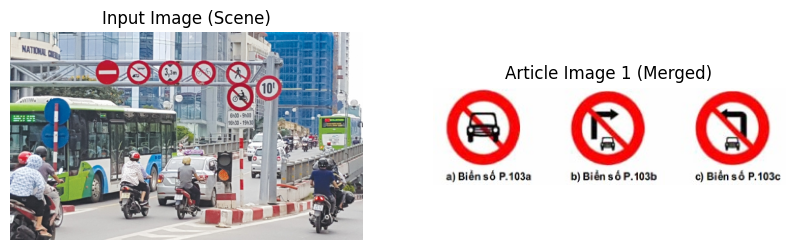

Processing Questions:   8%|▊         | 40/530 [01:05<29:13,  3.58s/it]


--- PROMPT SENT TO VLM ---
Bạn là một trợ lý chuyên phân tích luật giao thông. Nhiệm vụ của bạn là kết hợp thông tin từ nhiều nguồn để mô tả chính xác biển báo trong một hình ảnh tình huống giao thông cụ thể.

**NGUỒN THÔNG TIN ĐƯỢC CUNG CẤP:**

1.  **Hình ảnh Tình huống (Hình 1):** Đây là hình ảnh chính chứa biển báo cần phân tích.
2.  **Hình ảnh Luật (Hình 2):** Đây là các hình ảnh minh họa cho từng điều luật tương ứng.
3.  **Văn bản luật, Câu hỏi:** Cung cấp ngữ cảnh và mô tả chi tiết từ nhiều điều luật.

## THÔNG TIN CHI TIẾT:
**1. Câu hỏi:**
Trong khoảng thời gian từ 6:00 đến 9:00 và từ 16:30 đến 19:30, xe nào không được phép lưu thông trên đoạn đường này khi gặp biển hình tròn có hình xe máy?

**2. Các điều luật tham khảo:**
**Điều luật tham khảo 1 (QCVN 41:2024/BGTVT - B.3):**
a) Để báo đường cấm các loại xe cơ giới kể cả xe máy 3 bánh có thùng đi qua, trừ xe máy 2 bánh, xe gắn máy và các xe được ưu tiên theo quy định, đặt biển số P.103a “Cấm xe ôtô”
Nếu đường cấm vì lý 

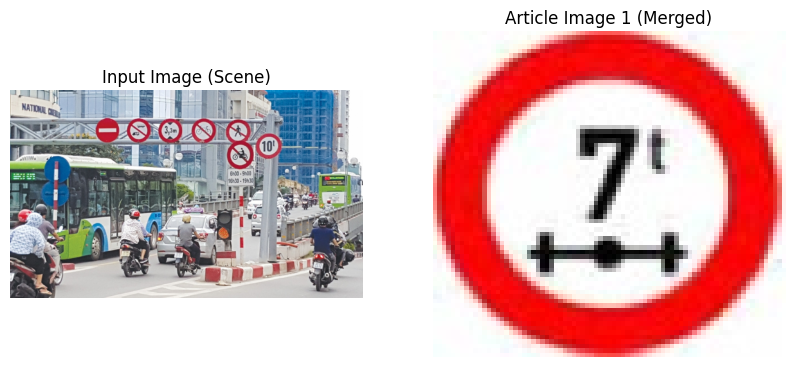

Processing Questions:   8%|▊         | 41/530 [01:35<45:31,  5.59s/it]


--- PROMPT SENT TO VLM ---
Bạn là một trợ lý chuyên phân tích luật giao thông. Nhiệm vụ của bạn là kết hợp thông tin từ nhiều nguồn để mô tả chính xác biển báo trong một hình ảnh tình huống giao thông cụ thể.

**NGUỒN THÔNG TIN ĐƯỢC CUNG CẤP:**

1.  **Hình ảnh Tình huống (Hình 1):** Đây là hình ảnh chính chứa biển báo cần phân tích.
2.  **Hình ảnh Luật (Hình 2):** Đây là các hình ảnh minh họa cho từng điều luật tương ứng.
3.  **Văn bản luật, Câu hỏi:** Cung cấp ngữ cảnh và mô tả chi tiết từ nhiều điều luật.

## THÔNG TIN CHI TIẾT:
**1. Câu hỏi:**
Biển báo "10t" có ý nghĩa gì và loại xe nào bị hạn chế lưu thông trên đoạn đường này?

**2. Các điều luật tham khảo:**
**Điều luật tham khảo 1 (QCVN 41:2024/BGTVT - B.16):**
Để báo đường cấm các xe (cơ giới và thô sơ) kể cả các xe được ưu tiên theo quy định, có trọng tải toàn bộ xe (cả xe và hàng) phân bổ trên một trục bất kỳ của xe (tải trọng trục xe) vượt quá trị số ghi trên biển đi qua, đặt biển số P.116 "Hạn chế tải trọng trên trục xe".



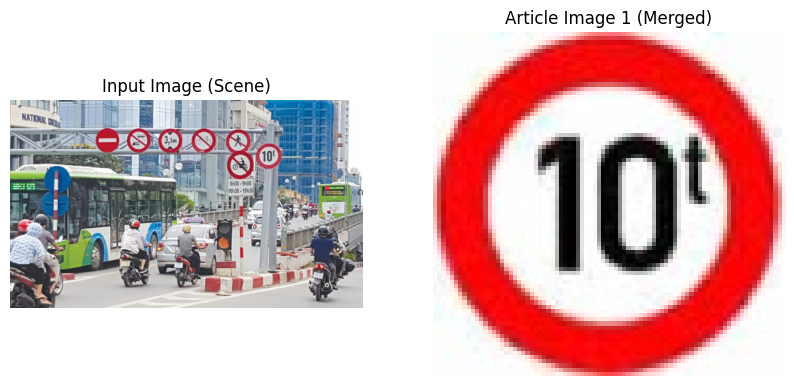

Processing Questions:   8%|▊         | 42/530 [02:01<1:00:38,  7.46s/it]


--- PROMPT SENT TO VLM ---
Bạn là một trợ lý chuyên phân tích luật giao thông. Nhiệm vụ của bạn là kết hợp thông tin từ nhiều nguồn để mô tả chính xác biển báo trong một hình ảnh tình huống giao thông cụ thể.

**NGUỒN THÔNG TIN ĐƯỢC CUNG CẤP:**

1.  **Hình ảnh Tình huống (Hình 1):** Đây là hình ảnh chính chứa biển báo cần phân tích.
2.  **Hình ảnh Luật (Hình 2):** Đây là các hình ảnh minh họa cho từng điều luật tương ứng.
3.  **Văn bản luật, Câu hỏi:** Cung cấp ngữ cảnh và mô tả chi tiết từ nhiều điều luật.

## THÔNG TIN CHI TIẾT:
**1. Câu hỏi:**
Biển báo "10t" yêu cầu phương tiện nào không được phép lưu thông trên đoạn đường này?

**2. Các điều luật tham khảo:**
**Điều luật tham khảo 1 (QCVN 41:2024/BGTVT - B.15):**
Để báo đường cấm các xe (cơ giới và thô sơ) kể cả các xe được ưu tiên theo quy định, có trọng tải toàn bộ xe (trọng tải bản thân xe cộng với khối lượng người, hành lý và hàng hóa xếp trên xe) vượt quá trị số ghi trên biển đi qua, đặt biển số P.115 "Hạn chế trọng tải toàn 

Processing Questions:  15%|█▌        | 80/530 [26:12<12:10:16, 97.37s/it]

🚨 Parsing Error: Could not find the expected markdown headers in the model output.
Raw Output:
---
### Tên biển báo
Trong hình ảnh Tình huống (Hình 1), biển báo màu xanh lá cây có chữ "H. THẠCH THANH TX. BÌM SƠN" và mũi tên chỉ về phía bên phải.

### Chi tiết luật
- **Biển số IE.464a:** Biển chỉ dẫn đường đi theo hướng thẳng hoặc trái, có hình chữ nhật, màu xanh lá cây, chữ trắng, chỉ dẫn hướng đi đến thành phố, thị xã, huyện, thị trấn, xã, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị trấn, thị t

Processing Questions:  16%|█▌        | 84/530 [28:15<6:10:28, 49.84s/it]

INFO: Skipping question 'train_85' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:  18%|█▊        | 93/530 [32:18<3:35:12, 29.55s/it]

INFO: Skipping question 'train_94' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:  18%|█▊        | 97/530 [34:08<3:50:46, 31.98s/it]

INFO: Skipping question 'train_98' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:  21%|██        | 110/530 [41:06<4:39:11, 39.88s/it]

INFO: Skipping question 'train_111' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:  21%|██        | 112/530 [41:44<3:30:44, 30.25s/it]

INFO: Skipping question 'train_113' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).
INFO: Skipping question 'train_114' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:  25%|██▌       | 135/530 [53:14<3:34:39, 32.61s/it]

INFO: Skipping question 'train_136' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:  28%|██▊       | 147/530 [57:11<1:21:04, 12.70s/it]

INFO: Skipping question 'train_146' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).
INFO: Skipping question 'train_147' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:  32%|███▏      | 168/530 [1:10:30<3:46:06, 37.48s/it]

INFO: Skipping question 'train_169' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:  32%|███▏      | 170/530 [1:11:17<3:06:26, 31.07s/it]

INFO: Skipping question 'train_171' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:  34%|███▎      | 178/530 [1:15:22<3:12:20, 32.79s/it]

INFO: Skipping question 'train_179' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:  35%|███▌      | 188/530 [1:20:25<3:27:07, 36.34s/it]

INFO: Skipping question 'train_189' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:  37%|███▋      | 196/530 [1:24:03<2:24:56, 26.04s/it]

INFO: Skipping question 'train_197' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).
INFO: Skipping question 'train_198' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).
INFO: Skipping question 'train_199' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:  38%|███▊      | 202/530 [1:25:35<1:49:05, 19.95s/it]

INFO: Skipping question 'train_203' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:  46%|████▌     | 242/530 [1:48:13<2:22:34, 29.70s/it]

INFO: Skipping question 'train_243' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:  47%|████▋     | 251/530 [1:51:44<2:01:45, 26.18s/it]

INFO: Skipping question 'train_252' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).
INFO: Skipping question 'train_253' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:  50%|█████     | 266/530 [1:59:11<2:25:09, 32.99s/it]

INFO: Skipping question 'train_267' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:  51%|█████     | 268/530 [1:59:40<1:47:28, 24.61s/it]

INFO: Skipping question 'train_269' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:  53%|█████▎    | 283/530 [2:08:34<3:07:39, 45.59s/it]

INFO: Skipping question 'train_284' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:  55%|█████▍    | 290/530 [2:11:56<2:08:33, 32.14s/it]

INFO: Skipping question 'train_291' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:  62%|██████▏   | 331/530 [2:33:06<1:52:23, 33.89s/it]

INFO: Skipping question 'train_332' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:  64%|██████▎   | 337/530 [2:35:38<1:32:45, 28.84s/it]

INFO: Skipping question 'train_338' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:  64%|██████▍   | 339/530 [2:36:06<1:11:07, 22.34s/it]

INFO: Skipping question 'train_340' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).
INFO: Skipping question 'train_341' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:  67%|██████▋   | 357/530 [2:50:50<4:41:05, 97.49s/it]

🚨 Parsing Error: Could not find the expected markdown headers in the model output.
Raw Output:
---
### Tên biển báo
Trong hình 1, chúng ta thấy biển báo "Cấm xe ô tô tải, xe quá tải, xe tải nhỏ, xe tải lớn, xe tải hạng nặng, xe tải hạng nhẹ, xe tải hạng trung, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải hạng nhẹ, xe tải h

Processing Questions:  68%|██████▊   | 362/530 [2:53:25<1:52:46, 40.28s/it]

INFO: Skipping question 'train_363' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:  74%|███████▍  | 393/530 [3:10:31<1:18:29, 34.38s/it]

INFO: Skipping question 'train_394' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:  76%|███████▌  | 401/530 [3:15:35<1:38:36, 45.87s/it]

CRITICAL: Inference failed for question 'train_402'. Details: height:11 and width:1 must be larger than factor:28
🚨 Parsing Error: Could not find the expected markdown headers in the model output.
Raw Output:
---
ERROR: height:11 and width:1 must be larger than factor:28
---


Processing Questions:  76%|███████▌  | 404/530 [3:16:41<1:07:38, 32.21s/it]

INFO: Skipping question 'train_405' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).
INFO: Skipping question 'train_406' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:  78%|███████▊  | 412/530 [3:20:31<1:03:36, 32.34s/it]

INFO: Skipping question 'train_413' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).
INFO: Skipping question 'train_414' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).
INFO: Skipping question 'train_415' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:  78%|███████▊  | 416/530 [3:20:56<31:28, 16.56s/it]  

INFO: Skipping question 'train_417' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:  80%|███████▉  | 423/530 [3:24:25<50:48, 28.49s/it]

INFO: Skipping question 'train_424' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:  81%|████████▏ | 431/530 [3:28:34<50:06, 30.37s/it]

INFO: Skipping question 'train_432' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:  82%|████████▏ | 434/530 [3:29:28<37:40, 23.55s/it]

INFO: Skipping question 'train_435' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:  84%|████████▍ | 447/530 [3:36:37<47:10, 34.10s/it]

INFO: Skipping question 'train_448' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:  86%|████████▌ | 455/530 [3:41:22<48:58, 39.19s/it]

INFO: Skipping question 'train_456' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:  86%|████████▌ | 457/530 [3:42:02<37:18, 30.66s/it]

INFO: Skipping question 'train_458' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:  88%|████████▊ | 466/530 [3:45:20<17:55, 16.80s/it]

INFO: Skipping question 'train_465' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).
INFO: Skipping question 'train_466' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions:  99%|█████████▊| 523/530 [4:23:08<04:07, 35.32s/it]

INFO: Skipping question 'train_524' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).


Processing Questions: 100%|██████████| 530/530 [4:24:00<00:00, 29.89s/it]


INFO: Skipping question 'train_527' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).
INFO: Skipping question 'train_528' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).
INFO: Skipping question 'train_529' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).
INFO: Skipping question 'train_530' because none of its relevant articles passed the required filters (e.g., law_id, article_id format, image count).

==================== PROCESSING COMPLETE ====================
Total Questions Attempted: 530
✅ Successfully Processed: 441
❌ Skipped (Image Not Found): 0
❌ Skipped (No Valid Articles): 89

🎉 Results for 441 questions saved to train_vision_rule_extraction_results.csv
🧹 Cleaning up VRAM...


In [9]:
# ===================================================================
# Block 7: Main Execution
# ===================================================================

def main():
    """Main function to run the script."""
    output_csv = "train_vision_rule_extraction_results.csv"
    try:
        print("📚 Loading training dataset...")
        questions, law_database = load_train_data()

        if not questions:
            print("Aborting run because no processable questions were loaded.")
            return

        print("\n🤖 Initializing Multi-Image VLM...")
        model_instance = MultiImageInference()
        
        run_vision_rule_extraction(
            model=model_instance,
            questions=questions, # Process all loaded questions
            laws=law_database,
            csv_path=output_csv,
            checks=3 # Number of sanity checks to display
        )
    except Exception as e:
        print(f"❌ A critical error occurred in the main function: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()